# Week 6: Colab Experiment

# I. Introduction
In this exercise, we apply dimension reduction methods and clustering algorithms to single-cell sequencing data.

# II. Methods
### Write Something

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import psutil
import matplotlib.cm as cm
import os
import scanpy as sc
from sklearn.metrics import silhouette_samples

os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
# Load the data and normalize the single-cell sequencing counts by total counts and log transform the counts
tasic2018 = np.load("../data/cell_data.npz") # Note that you need to change the path to your own

# data normalization
librarySizes = tasic2018['counts'].sum(axis=1)
CPM = tasic2018['counts'] / librarySizes.reshape(-1,1) * 1e+6
logCPM = np.log2(CPM + 1)

In [3]:
print(tasic2018.files)
for key in tasic2018.keys():
    print(f'{key}: {tasic2018[key].shape}')
    print(f'value: {tasic2018[key]}')

['counts', 'genes', 'clusters', 'areas', 'clusterColors', 'clusterNames']
counts: (23822, 3000)
value: [[   0.  652.  168. ...  138.    0. 5320.]
 [   0.  854.   11. ...   43.    0. 3147.]
 [   0.  182.   10. ...  387.    0. 4828.]
 ...
 [   0.  479.    0. ...   74.    0. 2840.]
 [   0.  177.   30. ...    0.    0. 8235.]
 [   0.   19.  141. ...  248.    0. 4941.]]
genes: (3000,)
value: ['0610040J01Rik' '1110008P14Rik' '1190002N15Rik' ... 'Zmat4' 'Zp2' 'Zwint']
clusters: (23822,)
value: [93 72  1 ... 88 34 56]
areas: (25481,)
value: [0 0 0 ... 1 1 1]
clusterColors: (133,)
value: ['#DDACC9' '#FF88AD' '#FFB8CE' '#DD6091' '#FF7290' '#FFA388' '#C77963'
 '#9440F3' '#9900B3' '#C266D1' '#6C00BF' '#A700FF' '#CA66FF' '#7779BF'
 '#8194CC' '#533691' '#9189FF' '#B09FFF' '#756FB3' '#9FAAFF' '#FF00FF'
 '#AF00E6' '#FF00B3' '#B3128A' '#FF4DC1' '#BD3D9A' '#882E81' '#AD589A'
 '#AC3491' '#FFFF00' '#FFBB33' '#804811' '#B06411' '#BF480D' '#CC6D3D'
 '#FFDF11' '#D6C300' '#FF8011' '#FF9F2C' '#FFB307' '#D9C566'

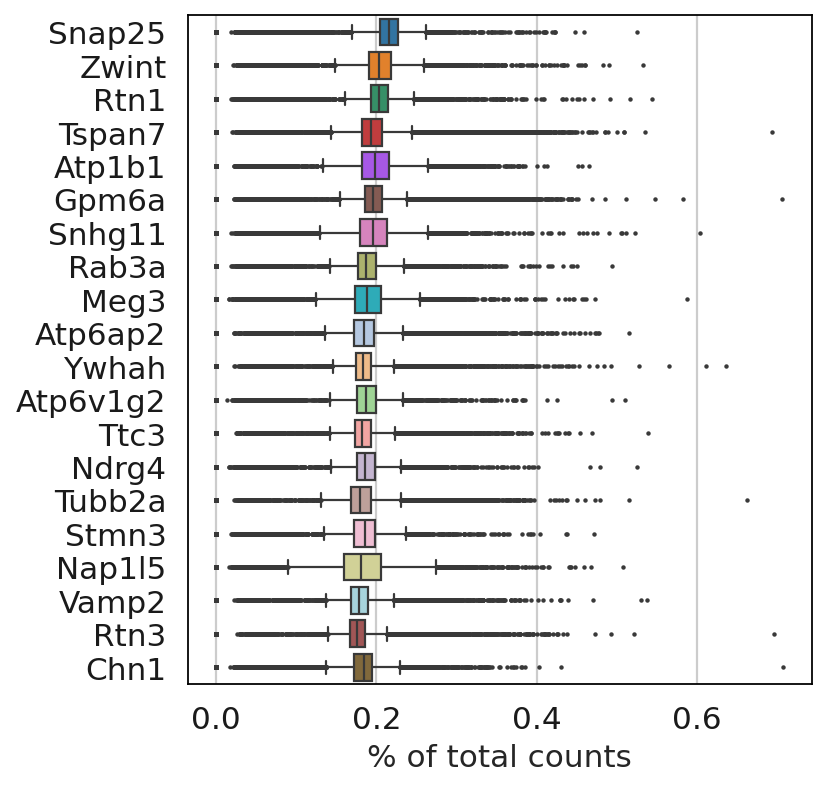

In [4]:
# Convert data to an AnnData object
adata = sc.AnnData(X=logCPM)
# adata.obs['areas'] = tasic2018['areas'][np.arange(len(adata.obs))]
# adata.obs['clusters'] = tasic2018['clusters']
# adata.uns['cluster_names'] = tasic2018['clusterNames']
# adata.obs_names = [f'Cell_{i}' for i in range(tasic2018['counts'].shape[0])]
adata.var_names = tasic2018['genes']

sc.settings.set_figure_params(dpi=80, facecolor="white")
sc.pl.highest_expr_genes(adata, n_top=20)

In [5]:
# TODO
# Implement PCA
# Note that storing your result in X or change the plt.scatter
# X = PCA_RESULT

n_components = 2
pca = PCA(n_components=n_components, svd_solver='full')
X = pca.fit_transform(logCPM)

print("Shape of PCA result:", X.shape)
print("Explained variance of each principal component:", pca.explained_variance_)
print("Explained variance ratio of each principal component:", pca.explained_variance_ratio_)
print("Estimated noise covariance:", pca.noise_variance_)

Shape of PCA result: (23822, 2)
Explained variance of each principal component: [2589.04060457 1606.86793705]
Explained variance ratio of each principal component: [0.18268801 0.11338389]
Estimated noise covariance: 3.3275568538270925


For 2 cluster, the average silhouette_score is : 0.7141
For 3 cluster, the average silhouette_score is : 0.831
For 4 cluster, the average silhouette_score is : 0.6978
For 5 cluster, the average silhouette_score is : 0.585
For 6 cluster, the average silhouette_score is : 0.5742
For 7 cluster, the average silhouette_score is : 0.4866
For 8 cluster, the average silhouette_score is : 0.4342
For 9 cluster, the average silhouette_score is : 0.4455
For 10 cluster, the average silhouette_score is : 0.4218
====== best n_clusters value is K = 3, best silhouette score is 0.831 ======


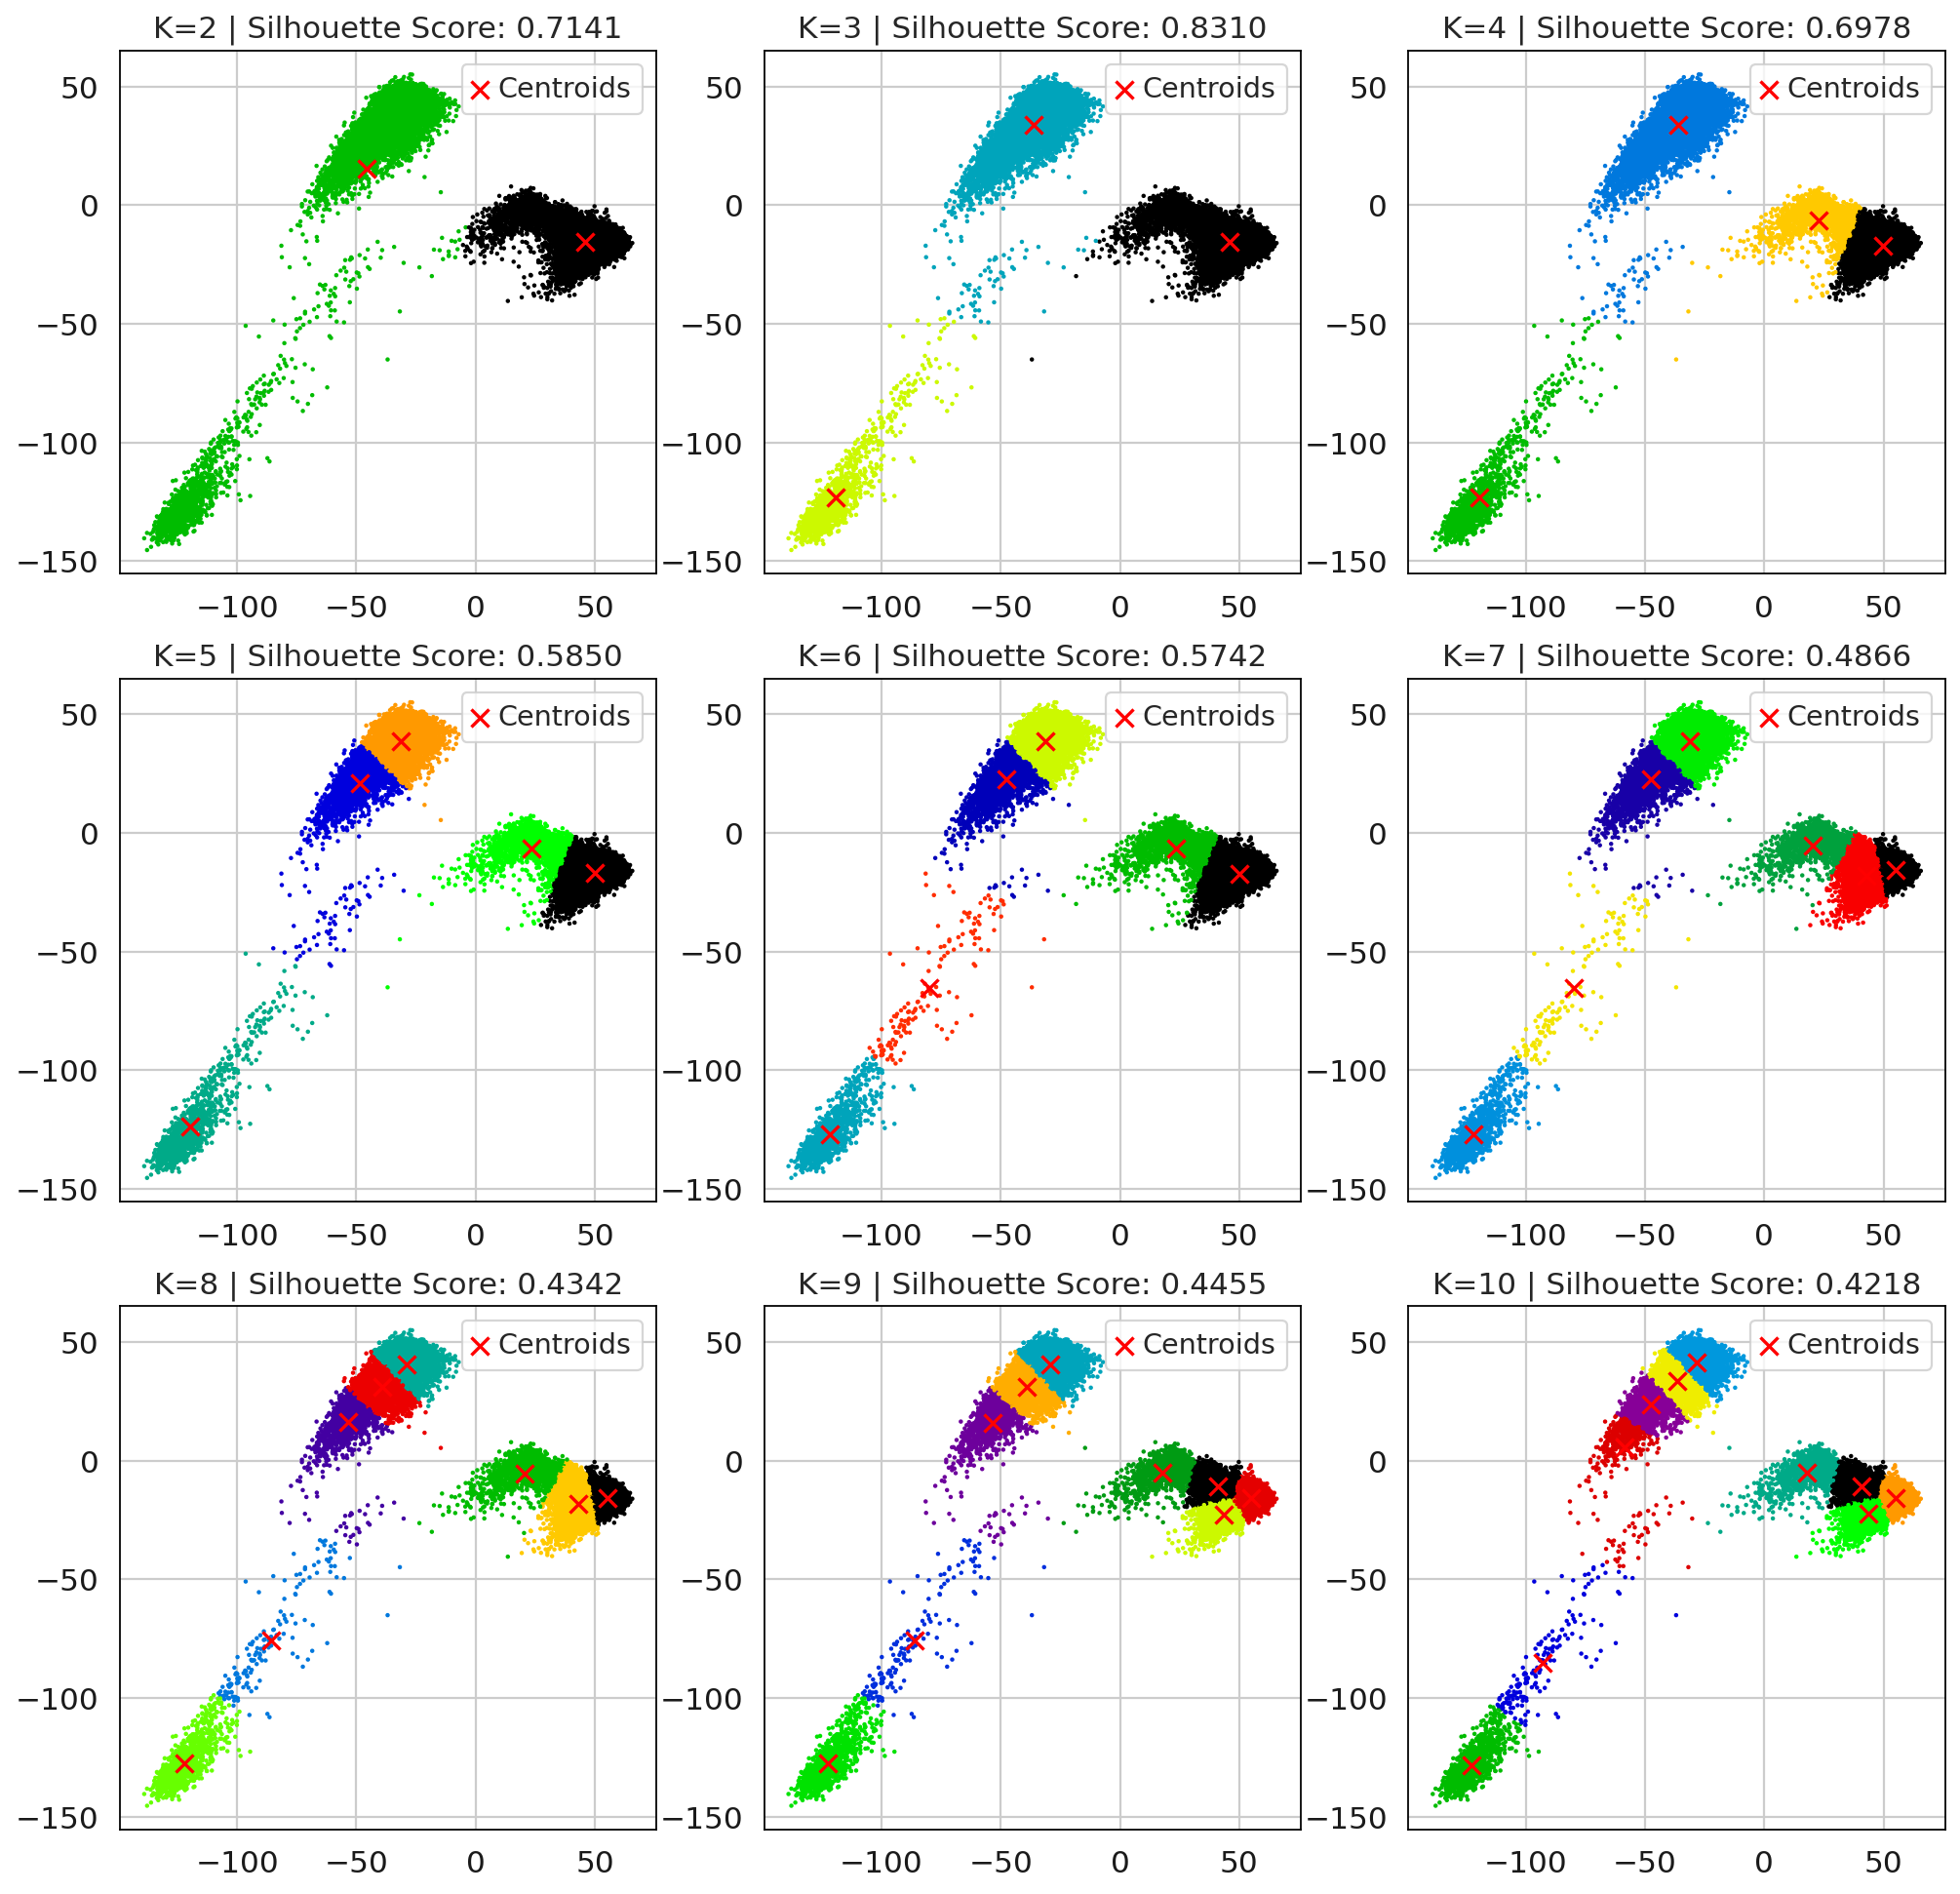

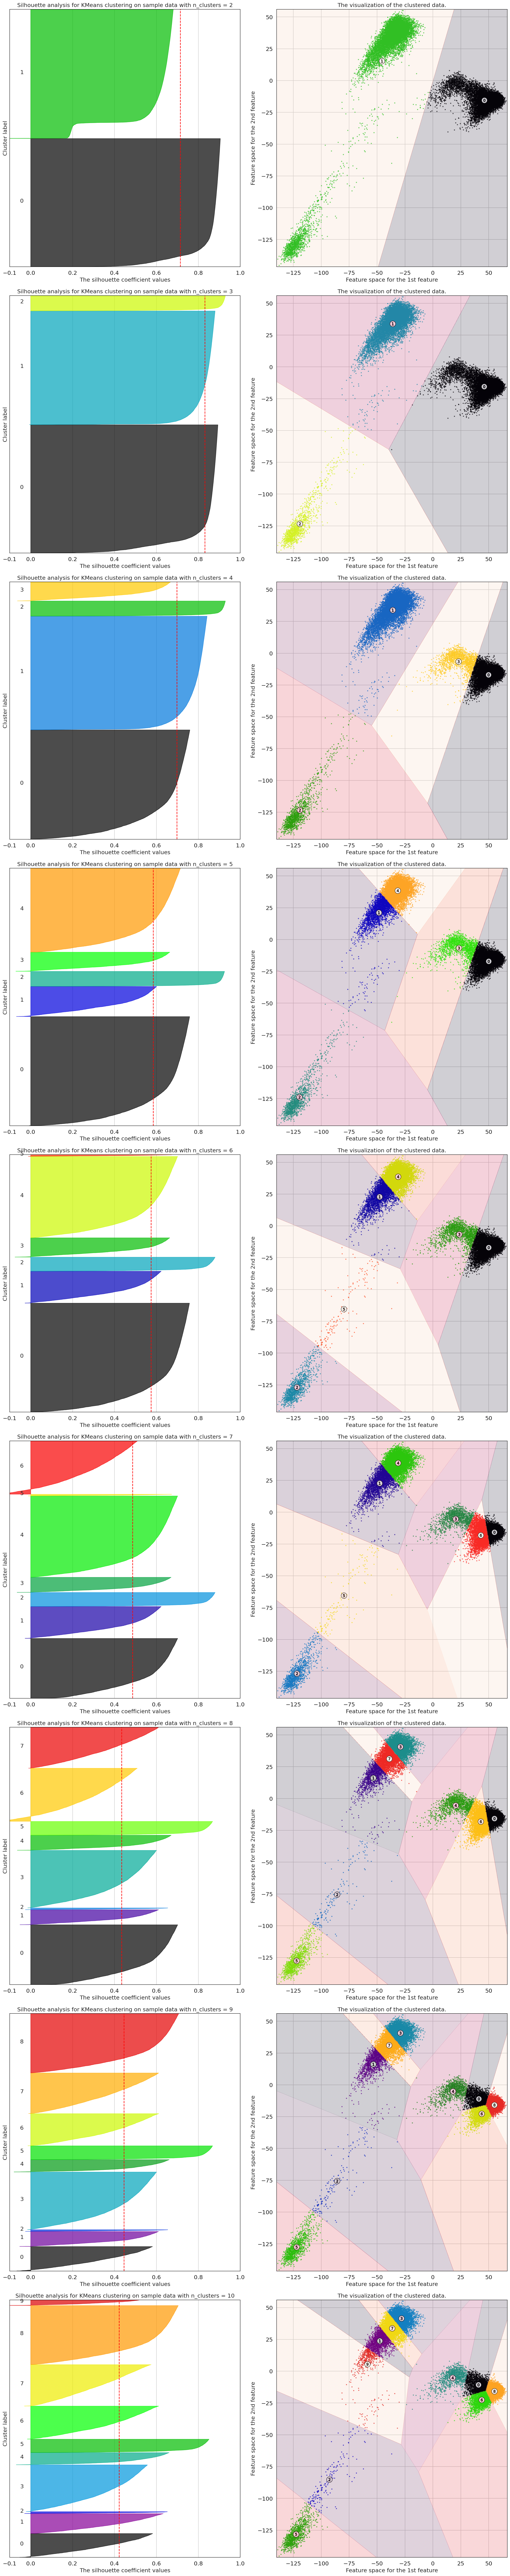

In [6]:
# TODO
# Implement K-Means

k_grid = range(2, 11, 1)
score = []

fig_mean, axs_mean = plt.subplots(3, 3, figsize=(15, 15))
fig_score, axs_score = plt.subplots(9, 2, figsize=(18, 90))
axs_mean = axs_mean.ravel()

for index, k_cluster in enumerate(k_grid):
    kmeans = KMeans(n_clusters=k_cluster, n_init='auto', random_state=0)
    score.append(silhouette_score(X, kmeans.fit_predict(X)))
    silhouette_coefficients = silhouette_samples(X, kmeans.labels_)

    print(
        f'For {k_cluster} cluster, the average silhouette_score is : {round(score[-1], 4)}'
    )

    # plot the centroids of the clusters
    colors = cm.nipy_spectral(kmeans.labels_.astype(float) / k_cluster)
    axs_mean[index].scatter(X[:, 0], X[:, 1], s=1, c=colors)
    axs_mean[index].scatter(kmeans.cluster_centers_[:, 0],
                            kmeans.cluster_centers_[:, 1],
                            c='red',
                            marker='x',
                            s=66,
                            label='Centroids')
    axs_mean[index].set_title(
        f'K={k_cluster} | Silhouette Score: {score[-1]:.4f}')
    axs_mean[index].legend()

    # silhouette analysis on k-means clustering
    # silhouette analysis: left side
    axs_score[index, 0].set_xlim([-0.1, 1])
    axs_score[index, 0].set_ylim([0, len(X) + (k_cluster + 1) * 10])

    y_lower = 10
    for cluster in range(k_cluster):
        ith_cluster_silhouette_coefficients = silhouette_coefficients[
            kmeans.labels_ == cluster]
        ith_cluster_silhouette_coefficients.sort()

        size_cluster_i = ith_cluster_silhouette_coefficients.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(cluster) / k_cluster)
        axs_score[index, 0].fill_betweenx(np.arange(y_lower, y_upper),
                                          0,
                                          ith_cluster_silhouette_coefficients,
                                          facecolor=color,
                                          edgecolor=color,
                                          alpha=0.7)
        axs_score[index, 0].text(-0.05, y_lower + 0.5 * size_cluster_i,
                                 str(cluster))
        y_lower = y_upper + 10

    axs_score[index, 0].set_title(
        f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {k_cluster}"
    )
    axs_score[index, 0].set_xlabel("The silhouette coefficient values")
    axs_score[index, 0].set_ylabel("Cluster label")
    axs_score[index, 0].axvline(x=score[-1], color="red", linestyle="--")
    axs_score[index, 0].set_yticks([])  # Clear the yaxis labels / ticks
    axs_score[index, 0].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # silhouette analysis: right side: cluster and labeled centroids
    axs_score[index, 1].scatter(X[:, 0],
                                X[:, 1],
                                marker=".",
                                s=30,
                                lw=0,
                                alpha=0.7,
                                c=colors,
                                edgecolor="k")
    centers = kmeans.cluster_centers_
    axs_score[index, 1].scatter(centers[:, 0],
                                centers[:, 1],
                                marker="o",
                                c="white",
                                alpha=1,
                                s=200,
                                edgecolor="k")
    for i, c in enumerate(centers):
        axs_score[index, 1].scatter(c[0],
                                    c[1],
                                    marker="$%d$" % i,
                                    alpha=1,
                                    s=50,
                                    edgecolor="k")

    axs_score[index, 1].set_title("The visualization of the clustered data.")
    axs_score[index, 1].set_xlabel("Feature space for the 1st feature")
    axs_score[index, 1].set_ylabel("Feature space for the 2nd feature")

    # silhouette analysis: right side: cluster countours
    if psutil.virtual_memory().total >= 50 * 1024**3:   # RAM >= 50 GB
        h = 0.02
        xx, yy = np.meshgrid(np.arange(X[:, 0].min() - 1, X[:, 0].max() + 1, h),
                            np.arange(X[:, 1].min() - 1, X[:, 1].max() + 1, h))
        Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        axs_score[index, 1].contourf(xx, yy, Z, alpha=0.2)
    else:
        print("RAM is not enough to plot the cluster countours")

print(
    f'====== best n_clusters value is K = {k_grid[np.argmax(score)]}, best silhouette score is {round(np.max(score), 4)} ======'
)
plt.tight_layout()
plt.show()

## III. Results

Here we show the scatter plot of the top 2 PCs. We also show the silhouette score with respect to the number of k-means clusters.

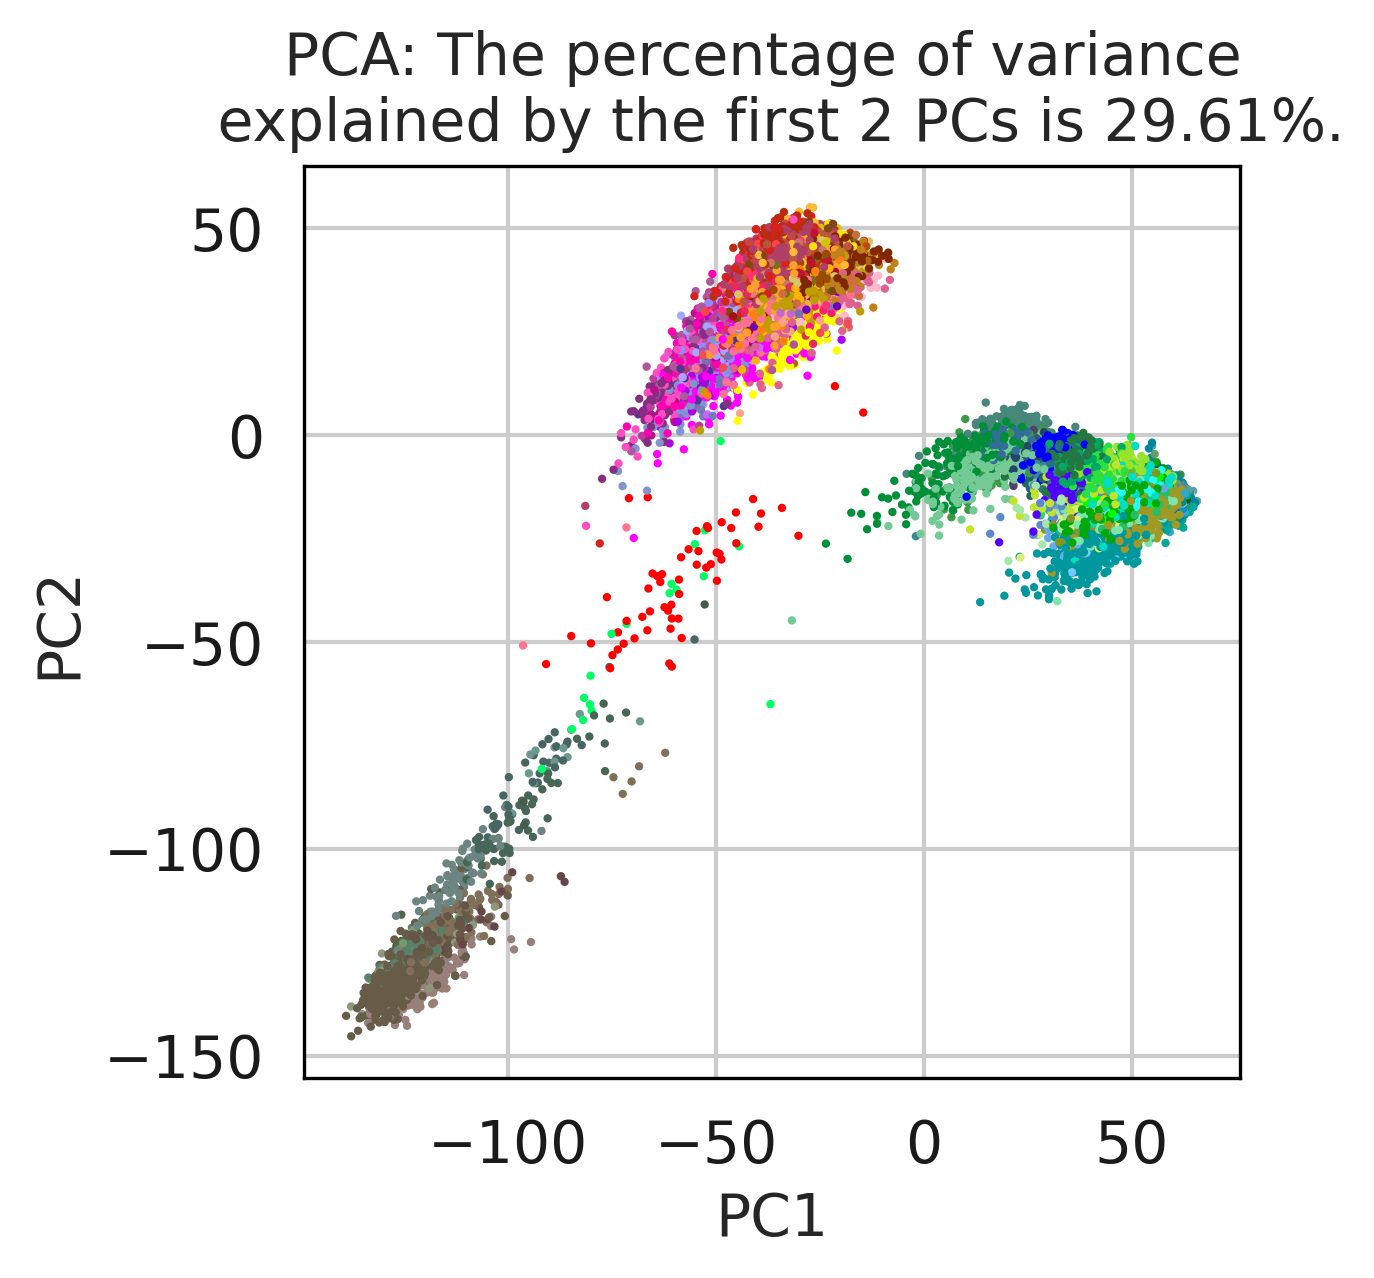

In [7]:
# Principal component analysis scatter plot
plt.figure(figsize=(4,4), dpi=150)
plt.scatter(X[:,0], X[:,1], s=1, color=tasic2018['clusterColors'][tasic2018['clusters']]) # Note that X is what you defined in PCA
plt.title(f"PCA: The percentage of variance \n explained by the first 2 PCs is {round(sum(pca.explained_variance_ratio_) * 100 , 2)}%.")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

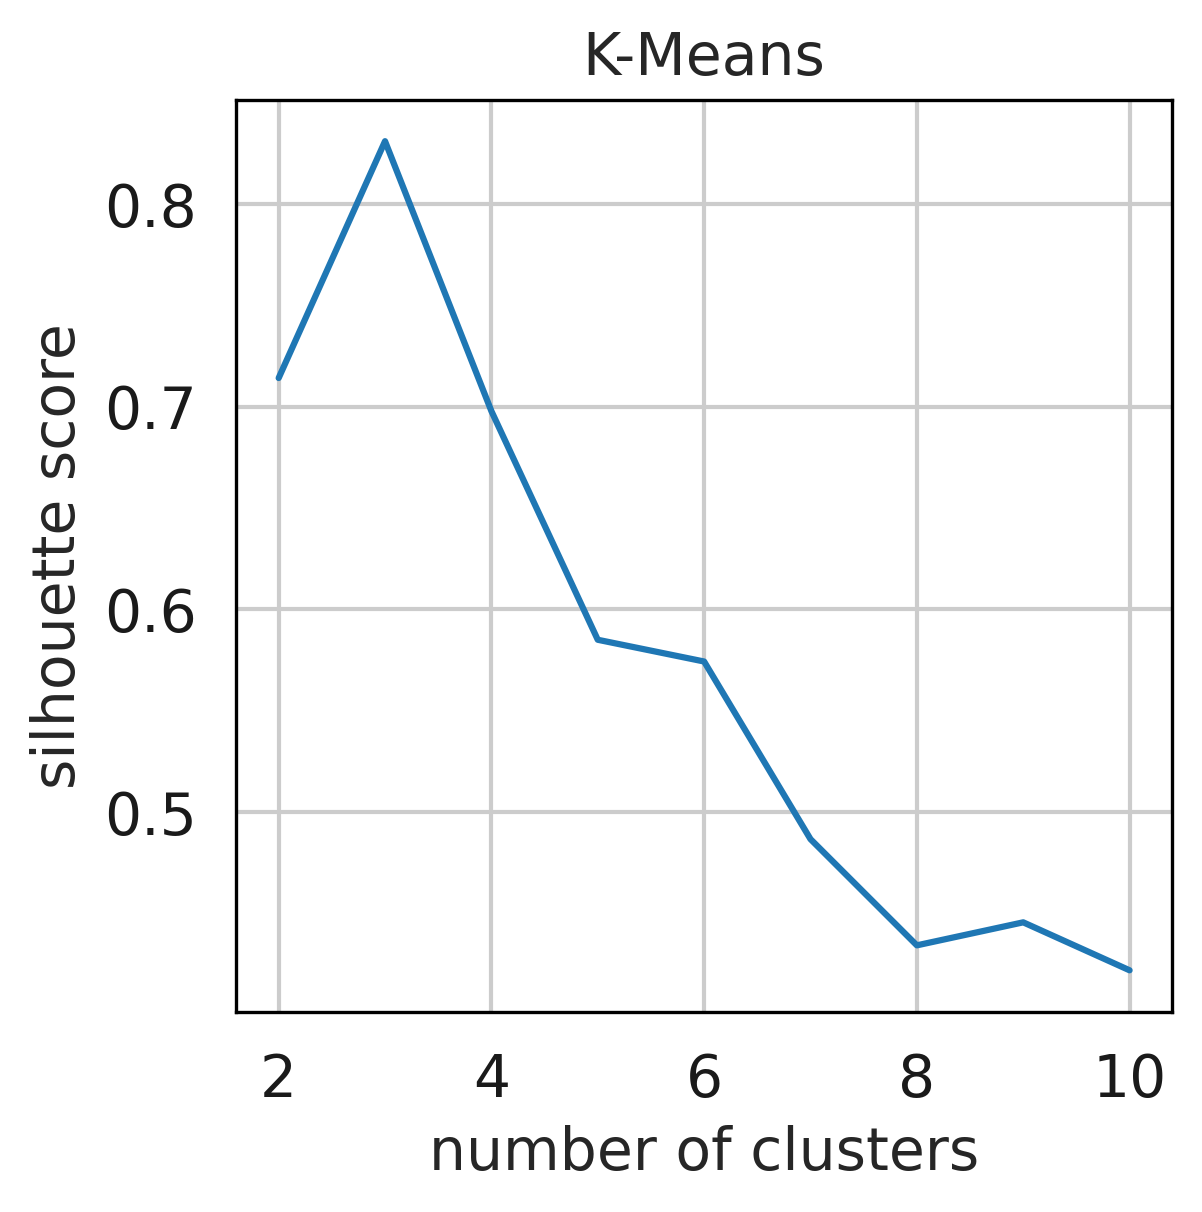

In [8]:
# k-means clustering performance
plt.figure(figsize=(4,4), dpi=150)
plt.plot(k_grid, score)
plt.title('K-Means')
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.show()

# IV. Conclusion and Discussion

### Please observe the plot image and write down your findings.

1. Import python packages
    
    Here, we configure OpenMP to utilize just one thread for parallel computations to prevent warnings during the k-means classification.

2. Load data and normalization

    In brief, we load the data and normalize the single-cell sequencing counts by total counts and log transform the counts. Data normalization adjusts raw counts to account for differences in sequencing depth across samples. The raw counts are converted to counts-per-million (CPM) by dividing each count by the library size (total counts) and then multiplying by 1,000,000. This process allows for a fair comparison of gene expression levels across cells and helps to stabilize variance by improving the data distribution.

3. Data exploration

    Given that the dataset is not predefined and unknown, we first extract and display its keys and values to gain insights into its contents. Following this, we convert the dataset into AnnData format and identify the genes that contribute the highest fraction of counts in each single cell, across all cells. The results indicate that most genes exhibit similar proportions, averaging around 0.2% of the total counts. Among them, Snap52, Zwint, and Rtn1 show the highest counts, ranking as the top three genes in terms of their fraction of total counts.

4. Principal Component Analysis (PCA)

    To facilitate effective clustering, we perform PCA on the normalized single-cell sequencing data. PCA transforms the original high-dimensional dataset into a lower-dimensional space while retaining the variance that is most informative for distinguishing the data. By selecting the top 2 principal components (as TA required), we can reduce noise and mitigate the curse of dimensionality, which enhances the performance of subsequent K-means clustering. After applying PCA, we will visualize the results to assess the distribution of data points in the reduced space and to aid in determining the optimal number of clusters for K-means.

5. K-means clustering with silhouette analysis

    To overcome the extensive technical noise in scRNA-seq data, it is common to cluster cells based on their PCA scores. In this step, we implement the K-means clustering algorithm across a range of cluster values, specifically from 2 to 10, while evaluating the performance using silhouette scores. Two sets of scatter plots are prepared for dispatching the result: one for visualizing the clustering results and another for conducting silhouette analysis.

    A loop iterates through each cluster value, fitting the K-means model to the data and calculating both the silhouette score and silhouette coefficients. For each configuration, the data points are plotted with colors indicating their assigned clusters, and the cluster centroids are marked with red "X" symbols.

    The left side of the silhouette analysis plot shows the silhouette values for each cluster, filled with color-coded areas, while the average silhouette score is indicated by a dashed red line. The right side visualizes the data points colored by their cluster membership, with labeled centroids. If sufficient RAM is available, contour plots are generated to illustrate the decision boundaries of the clusters.

    Finally, after evaluating all configurations, the optimal number of clusters is determined. When we set `K = 3`, the silhouette score has highest silhouette coefficient values, which means this is the optimal number for the single-cell sequencing.

6. Conclusions and discussions.

    In our PCA analysis, we find that the first two principal components (PCs) account for only 29.61% of the total variance, suggesting that they do not sufficiently represent the overall variance within the cluster. Nonetheless, the scatter plot reveals the presence of distinct clustering patterns. The explained variance for the first two PCs is reported as 2589.0406 and 1606.8679, with corresponding explained variance ratios of 0.1827 and  0.1134 respectively. Furthermore, the estimated noise covariance is approximately 3.3276. These findings imply that, although the first two PCs reveal some underlying structure in the data, they are inadequate for fully capturing the variability present in the dataset.

    In our K-means clustering analysis, we first visualized the centroids for k values ranging from 2 to 10. We then performed a comprehensive assessment of the silhouette coefficients. The silhouette analysis indicated that k=3 achieved the highest silhouette coefficient, at 0.8310, with all clusters surpassing the average silhouette score. However, as we increased k, a trend emerged where the average silhouette coefficient began to decrease, suggesting a potential reduction in clustering effectiveness. Furthermore, we not only plotted the silhouette values for each cluster but also illustrated the classification results within the clusters and included contour overlays. This methodology enhances our deeper understanding of the K-means outcomes and provides clearer insights into the clustering structures.

7. References
    - [Single Cell RNA-seq Clustering, Ahmed Mahfouz](https://nbisweden.github.io/excelerate-scRNAseq/session-clustering/Clustering.pdf)
    - [Selecting the number of clusters with silhouette analysis on KMeans clustering](https://scikit-learn.org/1.5/auto_examples/cluster/plot_kmeans_silhouette_analysis)
    - [A demo of K-Means clustering on the handwritten digits data](https://scikit-learn.org/1.5/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py)
